# ID2223 Scalable Machine Learning and Deep Learning - Lab 2
## Fine-Tuning and Deploying Large Language Models (LLMs)

**Authors:** Emanbuele Minotti, Stefano Romano

---

### 🎯 Lab Objectives & Approach

This notebook implements a complete pipeline for the fine-tuning of a Large Language Model (LLM) for instruction following and preparing it for efficient CPU-based inference.

---

### 🚀 Key Features of this Implementation:

1.  **Model Exploration & Hyperparameter Tuning (Task 2):**
    We did not rely on a single configuration. We trained and compared two different base models: **Llama-3.2-1B-Instruct** and **Llama-3.2-3B-Instruct**. Furthermore, we experimented with **LoRA parameters** (such as Rank `r` and Alpha `lora_alpha`) to improve the model's adaptation capabilities while managing the number of trainable parameters.

2.  **Objective Evaluation Metrics:**
    To rigorously assess performance, we split the **FineTome-100k** dataset into distinct **Training** and **Testing** sets. This allows us to calculate quantitative metrics like **Validation Loss** and **Perplexity**, providing an objective basis for selecting the best model rather than relying solely on subjective observation.

3.  **Resource-Aware Training Strategy:**
    Given the computational constraints of free Colab GPUs (T4), we limited the training process to **500 steps**. This trade-off balances sufficient learning with the strict runtime limits (1-4 hours), preventing timeouts while still demonstrating significant model adaptation. We utilize **Unsloth** with **4-bit quantization** (NF4) to further maximize efficiency.

4.  **Data-Centric Approach:**
    Instead of blindly ingesting the dataset, we analyze the data distribution to optimize parameters like `max_seq_length`. This ensures we are not wasting compute resources on excessive padding, adhering to the data-centric improvement requirement.

5.  **Robustness & Scalability (Checkpointing):**
    This notebook mounts **Google Drive** to store model checkpoints periodically. This ensures training resilience and allows the process to be resumed without data loss.

6.  **Deployment Preparation (GGUF Export):**
    To satisfy the requirement of building a UI that runs on CPU-only environments, the final model adapters are merged and exported to the **GGUF format**.

---

### 📋 Notebook Structure
1.  **Environment Setup:** Library installation and Google Drive mounting.
2.  **Data Analysis:** Inspecting the FineTome dataset.
3.  **Model Configuration:** Loading Llama-3.2-3B with 4-bit quantization.
4.  **Training:** Configuring the SFTTrainer with checkpointing enabled.
5.  **Inference & Evaluation:** Testing the fine-tuned model.
6.  **Export:** Saving to GGUF for the User Interface.

## Environment Setup & Persistent Storage

Establishes a connection to Google Drive to ensure training artifacts and model checkpoints are persisted.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

output_dir = "/content/drive/MyDrive/lama_8b"

Mounted at /content/drive


Silent installation of the latest nightly version of the Unsloth library and upgrade of Hugging Face dependencies to enable efficient, accelerated fine-tuning on Colab.

In [2]:
%%capture
!pip install unsloth
# Also get the latest nightly Unsloth!
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git@nightly git+https://github.com/unslothai/unsloth-zoo.git

!pip install -U "transformers" "huggingface_hub"

Initialization of the **Llama-3.2-3B-Instruct** base model using the Unsloth library. To fit the training process within the memory constraints of a free Colab GPU (T4), we enable **4-bit quantization** (`load_in_4bit=True`) and set the context window (`max_seq_length`) to 2048 tokens.

In [3]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Meta-Llama-3.1-8B-bnb-4bit",      # Llama-3.1 2x faster
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    "unsloth/Meta-Llama-3.1-70B-bnb-4bit",
    "unsloth/Meta-Llama-3.1-405B-bnb-4bit",    # 4bit for 405b!
    "unsloth/Mistral-Small-Instruct-2409",     # Mistral 22b 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/Phi-3.5-mini-instruct",           # Phi-3.5 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/gemma-2-9b-bnb-4bit",
    "unsloth/gemma-2-27b-bnb-4bit",            # Gemma 2x faster!

    "unsloth/Llama-3.2-1B-bnb-4bit",           # NEW! Llama 3.2 models
    "unsloth/Llama-3.2-1B-Instruct-bnb-4bit",
    "unsloth/Llama-3.2-3B-bnb-4bit",
    "unsloth/Llama-3.2-3B-Instruct-bnb-4bit",

    "unsloth/Llama-3.3-70B-Instruct-bnb-4bit" # NEW! Llama 3.3 70B!
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.11.6: Fast Llama patching. Transformers: 4.57.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.5.1
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [4]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 32, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 32,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = True,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2025.11.6 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


<a name="Data"></a>
### Data Prep
We now use the `Llama-3.1` format for conversation style finetunes. We use [Maxime Labonne's FineTome-100k](https://huggingface.co/datasets/mlabonne/FineTome-100k) dataset in ShareGPT style. But we convert it to HuggingFace's normal multiturn format `("role", "content")` instead of `("from", "value")`/ Llama-3 renders multi turn conversations like below:

```
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

Hello!<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Hey there! How are you?<|eot_id|><|start_header_id|>user<|end_header_id|>

I'm great thanks!<|eot_id|>
```

We use our `get_chat_template` function to get the correct chat template. We support `zephyr, chatml, mistral, llama, alpaca, vicuna, vicuna_old, phi3, llama3` and more.

In [5]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama-3.1",
)

def formatting_prompts_func(examples):
    convos = examples["conversations"]
    texts = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False) for convo in convos]
    return { "text" : texts, }
pass

from datasets import load_dataset
dataset = load_dataset("mlabonne/FineTome-100k", split = f"train[:10000]")

README.md:   0%|          | 0.00/982 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/117M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]

We now use `standardize_sharegpt` to convert ShareGPT style datasets into HuggingFace's generic format. This changes the dataset from looking like:
```
{"from": "system", "value": "You are an assistant"}
{"from": "human", "value": "What is 2+2?"}
{"from": "gpt", "value": "It's 4."}
```
to
```
{"role": "system", "content": "You are an assistant"}
{"role": "user", "content": "What is 2+2?"}
{"role": "assistant", "content": "It's 4."}
```

In [8]:
from unsloth.chat_templates import standardize_sharegpt
dataset = standardize_sharegpt(dataset)
dataset = dataset.map(formatting_prompts_func, batched = True,)
dataset = dataset.train_test_split(test_size=0.1)

Unsloth: Standardizing formats (num_proc=2):   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

<a name="Train"></a>
### Train the model (with Checkpointing & Evaluation)
Now let's use Hugging Face TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer).

To ensure a robust training process within Colab's resource limits, we have configured the following parameters:
* **`max_steps = 500`**: We limit training to 500 steps to ensure the process completes within the runtime limit while still providing significant adaptation.
* **`save_steps = 50`**: We save model checkpoints to Google Drive every 50 steps. This is critical for data persistence; if the session disconnects, we can resume from the last saved state.
* **`eval_steps = 50`**: We evaluate the model on the test split every 50 steps to calculate Validation Loss and monitor for overfitting in real-time.

In [9]:
from trl import SFTTrainer
from transformers import TrainingArguments, DataCollatorForSeq2Seq
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset["train"],
    eval_dataset = dataset["test"],
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    data_collator = DataCollatorForSeq2Seq(tokenizer = tokenizer),
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 8,
        warmup_steps = 5,
        # num_train_epochs = 1, # Set this for 1 full training run.
        max_steps = 500,
        learning_rate = 1e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = output_dir,
        report_to = "none", # Use this for WandB etc

        save_steps = 50, # Save checkpoint every 50 steps
        save_strategy = "steps", # Save based on steps
        save_total_limit = 1,

        eval_strategy = "steps",
        eval_steps = 50, # Calculate val loss every 500 steps
        per_device_eval_batch_size = 2,
        load_best_model_at_end = True,
    ),
)

Unsloth: Tokenizing ["text"] (num_proc=6):   0%|          | 0/9000 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=6):   0%|          | 0/1000 [00:00<?, ? examples/s]

We also use Unsloth's `train_on_completions` method to only train on the assistant outputs and ignore the loss on the user's inputs.

In [10]:
from unsloth.chat_templates import train_on_responses_only
trainer = train_on_responses_only(
    trainer,
    instruction_part = "<|start_header_id|>user<|end_header_id|>\n\n",
    response_part = "<|start_header_id|>assistant<|end_header_id|>\n\n",
)

Map (num_proc=6):   0%|          | 0/9000 [00:00<?, ? examples/s]

Map (num_proc=6):   0%|          | 0/1000 [00:00<?, ? examples/s]

We verify masking is actually done:

In [11]:
tokenizer.decode(trainer.train_dataset[5]["input_ids"])

"<|begin_of_text|><|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 26 July 2024\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nDescribe the working of a recursive function and analyze its time complexity. Explain how memoization can optimize the recursive function's performance, providing a practical example.<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nA recursive function is a function that calls itself to solve a problem. It breaks the problem down into smaller and more manageable sub-problems, solving each sub-problem only once, stores their results, and uses the stored results to construct the solution to the original problem. \n\nLet's consider the problem of calculating the Factorial of a number 'n', i.e., n!.\n\nWithout Memoization:\n```\nfunction factorial(n) {\n    if(n == 0 || n == 1) return 1; \n    return n * factorial(n - 1);\n}\n```\nIn the above function, the time complexity is O(n) 

In [12]:
space = tokenizer(" ", add_special_tokens = False).input_ids[0]
tokenizer.decode([space if x == -100 else x for x in trainer.train_dataset[5]["labels"]])

"                                                                  A recursive function is a function that calls itself to solve a problem. It breaks the problem down into smaller and more manageable sub-problems, solving each sub-problem only once, stores their results, and uses the stored results to construct the solution to the original problem. \n\nLet's consider the problem of calculating the Factorial of a number 'n', i.e., n!.\n\nWithout Memoization:\n```\nfunction factorial(n) {\n    if(n == 0 || n == 1) return 1; \n    return n * factorial(n - 1);\n}\n```\nIn the above function, the time complexity is O(n) because it makes 'n' recursive calls.\n\nMemoization is a technique of caching and reusing previously computed results to speed up complex computations. It optimizes a recursive function's performance by keeping track of the previously solved solutions, which prevents those solutions from being computed again.\n\nHere's the factorial function implemented with memoization:\n`

We can see the System and Instruction prompts are successfully masked!

In [13]:
trainer_stats = trainer.train(resume_from_checkpoint=True)

The model is already on multiple devices. Skipping the move to device specified in `args`.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 9,000 | Num Epochs = 1 | Total steps = 500
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 8 x 1) = 8
 "-____-"     Trainable parameters = 83,886,080 of 8,114,147,328 (1.03% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss


## Stage 2 — Domain-Specific Refinement
This block performs a short refinement pass on a small dataset of pet-care dialogues.


In [14]:
from datasets import load_dataset
from trl import SFTTrainer
from transformers import TrainingArguments, DataCollatorForSeq2Seq
from unsloth.chat_templates import train_on_responses_only
from unsloth import is_bfloat16_supported

# Load your custom JSONL dataset
vetai_path = "/content/drive/MyDrive/lama_8b/vetai_dataset_100.jsonl"  # change path if needed
vetai_dataset = load_dataset("json", data_files=vetai_path, split="train")

# Apply chat template
def format_vetai(batch):
    return {
        "text": [
            tokenizer.apply_chat_template(
                item, tokenize=False, add_generation_prompt=False
            )
            for item in batch["messages"]
        ]
    }

vetai_dataset = vetai_dataset.map(format_vetai, batched=True)

# Tiny train/test split
vetai_dataset = vetai_dataset.train_test_split(test_size=0.1)

trainer_vetai = SFTTrainer(
    model = model,  # reuse your already trained LoRA model
    tokenizer = tokenizer,
    train_dataset = vetai_dataset["train"],
    eval_dataset = vetai_dataset["test"],
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    data_collator = DataCollatorForSeq2Seq(tokenizer),
    args = TrainingArguments(
        output_dir = output_dir,
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 2,
        learning_rate = 5e-5,
        num_train_epochs = 1,  # quick refinement
        warmup_steps = 2,
        logging_steps = 1,
        bf16 = is_bfloat16_supported(),
        fp16 = not is_bfloat16_supported(),
        optim = "adamw_8bit",
        save_strategy = "no",
        eval_strategy = "epoch",
        report_to = "none",
    ),
)

trainer_vetai = train_on_responses_only(
    trainer_vetai,
    instruction_part="<|start_header_id|>user<|end_header_id|>\n\n",
    response_part="<|start_header_id|>assistant<|end_header_id|>\n\n",
)

print("Starting quick VetAI refinement...")
trainer_vetai.train()
print("Refinement completed!")


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/98 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=6):   0%|          | 0/88 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=6):   0%|          | 0/10 [00:00<?, ? examples/s]

Map (num_proc=6):   0%|          | 0/88 [00:00<?, ? examples/s]

Map (num_proc=6):   0%|          | 0/10 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.


Starting quick VetAI refinement...


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 88 | Num Epochs = 1 | Total steps = 44
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 2 x 1) = 2
 "-____-"     Trainable parameters = 83,886,080 of 8,114,147,328 (1.03% trained)


Epoch,Training Loss,Validation Loss
1,1.612500,1.543397


Unsloth: Not an error, but LlamaForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


Refinement completed!


### Metric Extraction

--- BASELINE RESULTS ---
Lowest Validation Loss: 0.6474162936210632
Best Perplexity: 1.9105980220854124


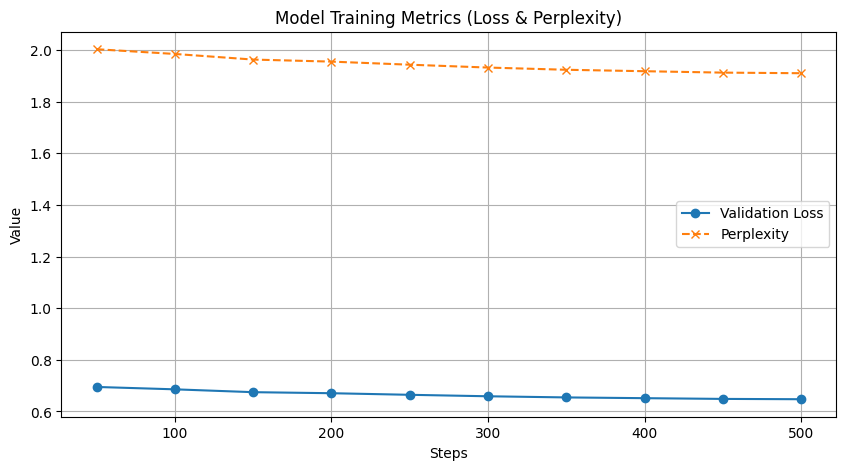

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Get the logs from the trainer history
history = trainer.state.log_history
df = pd.DataFrame(history)

# Extract Eval Loss and Calculate Perplexity
# Filter only rows that have 'eval_loss'
eval_data = df.dropna(subset=['eval_loss']).copy()

# Calculate Perplexity = exp(eval_loss)
eval_data['perplexity'] = np.exp(eval_data['eval_loss'])

# Display Results
if not eval_data.empty:
    print("--- BASELINE RESULTS ---")
    print(f"Lowest Validation Loss: {eval_data['eval_loss'].min()}")
    print(f"Best Perplexity: {eval_data['perplexity'].min()}")

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(eval_data['step'], eval_data['eval_loss'], label='Validation Loss', marker='o')
    plt.plot(eval_data['step'], eval_data['perplexity'], label='Perplexity', linestyle='--', marker='x')
    plt.xlabel('Steps')
    plt.ylabel('Value')
    plt.title('Model Training Metrics (Loss & Perplexity)')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No validation metrics found. Did you set evaluation_strategy='steps'?")

<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!

We use `min_p = 0.1` and `temperature = 1.5`. Read this [Tweet](https://x.com/menhguin/status/1826132708508213629) for more information on why.

In [16]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama-3.1",
)
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

messages = [
    {"role": "user", "content": "Continue the fibonnaci sequence: 1, 1, 2, 3, 5, 8,"},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")

outputs = model.generate(input_ids = inputs, max_new_tokens = 64, use_cache = True,
                         temperature = 1.5, min_p = 0.1)
tokenizer.batch_decode(outputs)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


['<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 26 July 2024\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nContinue the fibonnaci sequence: 1, 1, 2, 3, 5, 8,<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n11, 18, 29,<|eot_id|>']

 You can also use a `TextStreamer` for continuous inference - so you can see the generation token by token, instead of waiting the whole time!

In [17]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

messages = [
    {"role": "user", "content": "Continue the fibonnaci sequence: 1, 1, 2, 3, 5, 8,"},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(input_ids = inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

8, 13, 21<|eot_id|>


<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [18]:
model.save_pretrained(output_dir) # Local saving
tokenizer.save_pretrained(output_dir)
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

('/content/drive/MyDrive/lama_8b/tokenizer_config.json',
 '/content/drive/MyDrive/lama_8b/special_tokens_map.json',
 '/content/drive/MyDrive/lama_8b/chat_template.jinja',
 '/content/drive/MyDrive/lama_8b/tokenizer.json')

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [ ]:
if False:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference

messages = [
    {"role": "user", "content": "Describe a tall tower in the capital of France."},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(input_ids = inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

The tower stands tall at an impressive 324 meters. Built from reinforced concrete and steel, it was completed in 1889 during the World's Fair that was held in Paris. It has been a symbol of France and one of its most iconic landmarks ever since.<|eot_id|>


### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16 or `merged_4bit` for int4. We also allow `lora` adapters as a fallback. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [ ]:
# Merge to 16bit
if True: model.save_pretrained_merged(output_dir, tokenizer, save_method = "merged_16bit",)
if True: model.push_to_hub_merged("stromano02/model", tokenizer, save_method = "merged_16bit", token = "")
if False: model.push_to_hub_merged("emaminotti/model", tokenizer, save_method = "merged_16bit", token = "")


# Merge to 4bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_4bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_4bit", token = "")

# Just LoRA adapters
if False: model.save_pretrained_merged("model", tokenizer, save_method = "lora",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "lora", token = "")

Found HuggingFace hub cache directory: /root/.cache/huggingface/hub
Checking cache directory for required files...
Cache check failed: model-00001-of-00004.safetensors not found in local cache.
Not all required files found in cache. Will proceed with downloading.
Checking cache directory for required files...
Cache check failed: tokenizer.model not found in local cache.
Not all required files found in cache. Will proceed with downloading.


Unsloth: Preparing safetensor model files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Unsloth: Preparing safetensor model files:  25%|██▌       | 1/4 [01:38<04:54, 98.09s/it]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Unsloth: Preparing safetensor model files:  50%|█████     | 2/4 [04:52<05:09, 154.59s/it]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Unsloth: Preparing safetensor model files:  75%|███████▌  | 3/4 [07:16<02:29, 149.69s/it]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Unsloth: Preparing safetensor model files: 100%|██████████| 4/4 [07:51<00:00, 117.95s/it]


Note: tokenizer.model not found (this is OK for non-SentencePiece models)


Unsloth: Merging weights into 16bit: 100%|██████████| 4/4 [13:37<00:00, 204.27s/it]


Unsloth: Merge process complete. Saved to `/content/drive/MyDrive/lama_8b`


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...no02/model/tokenizer.json: 100%|##########| 17.2MB / 17.2MB            

Found HuggingFace hub cache directory: /root/.cache/huggingface/hub


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Checking cache directory for required files...
Cache check failed: model-00001-of-00004.safetensors not found in local cache.
Not all required files found in cache. Will proceed with downloading.
Checking cache directory for required files...
Cache check failed: tokenizer.model not found in local cache.
Not all required files found in cache. Will proceed with downloading.


Unsloth: Preparing safetensor model files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Unsloth: Preparing safetensor model files:  25%|██▌       | 1/4 [06:35<19:47, 395.83s/it]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Unsloth: Preparing safetensor model files:  50%|█████     | 2/4 [12:05<11:53, 356.63s/it]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Unsloth: Preparing safetensor model files:  75%|███████▌  | 3/4 [17:17<05:36, 336.67s/it]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Unsloth: Preparing safetensor model files: 100%|██████████| 4/4 [18:12<00:00, 273.04s/it]


Note: tokenizer.model not found (this is OK for non-SentencePiece models)


Unsloth: Merging weights into 16bit:   0%|          | 0/4 [00:00<?, ?it/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...0001-of-00004.safetensors:   1%|          | 33.6MB / 4.98GB            

Unsloth: Merging weights into 16bit:  25%|██▌       | 1/4 [05:27<16:21, 327.25s/it]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...0002-of-00004.safetensors:   0%|          |  612kB / 5.00GB            

Unsloth: Merging weights into 16bit:  50%|█████     | 2/4 [09:33<09:19, 279.54s/it]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...0003-of-00004.safetensors:   0%|          |  613kB / 4.92GB            

Unsloth: Merging weights into 16bit:  75%|███████▌  | 3/4 [13:47<04:28, 268.11s/it]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...0004-of-00004.safetensors:   4%|3         | 41.9MB / 1.17GB            

Unsloth: Merging weights into 16bit: 100%|██████████| 4/4 [14:52<00:00, 223.24s/it]


Unsloth: Merge process complete. Saved to `/content/stromano02/model`


### GGUF / llama.cpp Conversion

In [ ]:
import os
if not os.path.isdir("llama.cpp"):
    !git clone https://github.com/ggerganov/llama.cpp.git

if True:
    quantization_method = "q8_0"

    !python llama.cpp/convert_hf_to_gguf.py {output_dir} \
        --outfile {output_dir}/llama-3.2-8b-finetuned.gguf \
        --outtype {quantization_method}

Cloning into 'llama.cpp'...
remote: Enumerating objects: 70987, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 70987 (delta 7), reused 3 (delta 3), pack-reused 70967 (from 2)
Receiving objects: 100% (70987/70987), 224.56 MiB | 34.50 MiB/s, done.
Resolving deltas: 100% (51310/51310), done.
INFO:hf-to-gguf:Loading model: lama_8b
INFO:hf-to-gguf:Model architecture: LlamaForCausalLM
INFO:hf-to-gguf:gguf: loading model weight map from 'model.safetensors.index.json'
INFO:hf-to-gguf:gguf: indexing model part 'model-00004-of-00004.safetensors'
INFO:hf-to-gguf:gguf: indexing model part 'model-00003-of-00004.safetensors'
INFO:hf-to-gguf:gguf: indexing model part 'model-00001-of-00004.safetensors'
INFO:hf-to-gguf:gguf: indexing model part 'model-00002-of-00004.safetensors'
INFO:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
INFO:hf-to-gguf:Exporting model...
INFO:hf-to-gguf:rope_freqs.weight,           torch.floa

In [ ]:
if False: model.push_to_hub_merged("emaminotti/model", tokenizer, save_method = "merged_16bit", token = "")
if True: model.push_to_hub_merged("stromano02/model", tokenizer, save_method = "merged_16bit", token = "")

if False: model.push_to_hub_gguf("emaminotti/model", tokenizer, quantization_method = "q8_0", token = "")
if True: model.push_to_hub_gguf("stromano02/model", tokenizer, quantization_method = "q8_0", token = "")


No files have been modified since last commit. Skipping to prevent empty commit.


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...no02/model/tokenizer.json: 100%|##########| 17.2MB / 17.2MB            

No files have been modified since last commit. Skipping to prevent empty commit.


Found HuggingFace hub cache directory: /root/.cache/huggingface/hub


model.safetensors.index.json: 0.00B [00:00, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


Checking cache directory for required files...
Cache check failed: model-00001-of-00004.safetensors not found in local cache.
Not all required files found in cache. Will proceed with downloading.
Checking cache directory for required files...
Cache check failed: tokenizer.model not found in local cache.
Not all required files found in cache. Will proceed with downloading.


Unsloth: Preparing safetensor model files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Unsloth: Preparing safetensor model files:  25%|██▌       | 1/4 [03:30<10:31, 210.39s/it]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

## 📌 Performance Comparison Across Fine-Tuned Models

We fine-tuned three language models using parameter-efficient LoRA training with increasing model sizes.  
The objective was to demonstrate **measurable performance improvement**.

### 🔹 Models Trained and Hyperparameters

| Model | LoRA Rank | LoRA Alpha | Learning Rate | Train Batch Size | Gradient Accumulation | Lowest Validation Loss | Best Perplexity |
|------|-----------|------------|---------------|------------------|-----------------------|------------------------|-----------------|
| **Llama-3.2-1B** | 16 | 16 | 2e-4 | 2 | 4 | **0.8906** | **2.4366** |
| **Llama-3.2-3B** | 16 | 16 | 2e-4 | 2 | 4 | **0.7266** | **2.0680** |
| **Meta-Llama-3.1-8B** | 32 | 32 | 1e-4 | 1 | 8 | **0.6474** | **1.9106** |

✔️ *There is a consistent improvement as model capacity increases — both validation loss and perplexity decrease.*

---

## 📈 Training Curves Comparison

Each model was trained for **500 steps**, with **evaluation every 50 steps**.  
Below we include the plots for validation loss and perplexity for each run.

---

### 🔹 Llama-3.2-1B (LoRA Rank = 16, Alpha = 16)

![](/content/drive/MyDrive/lama_8b/plots/1b.png)
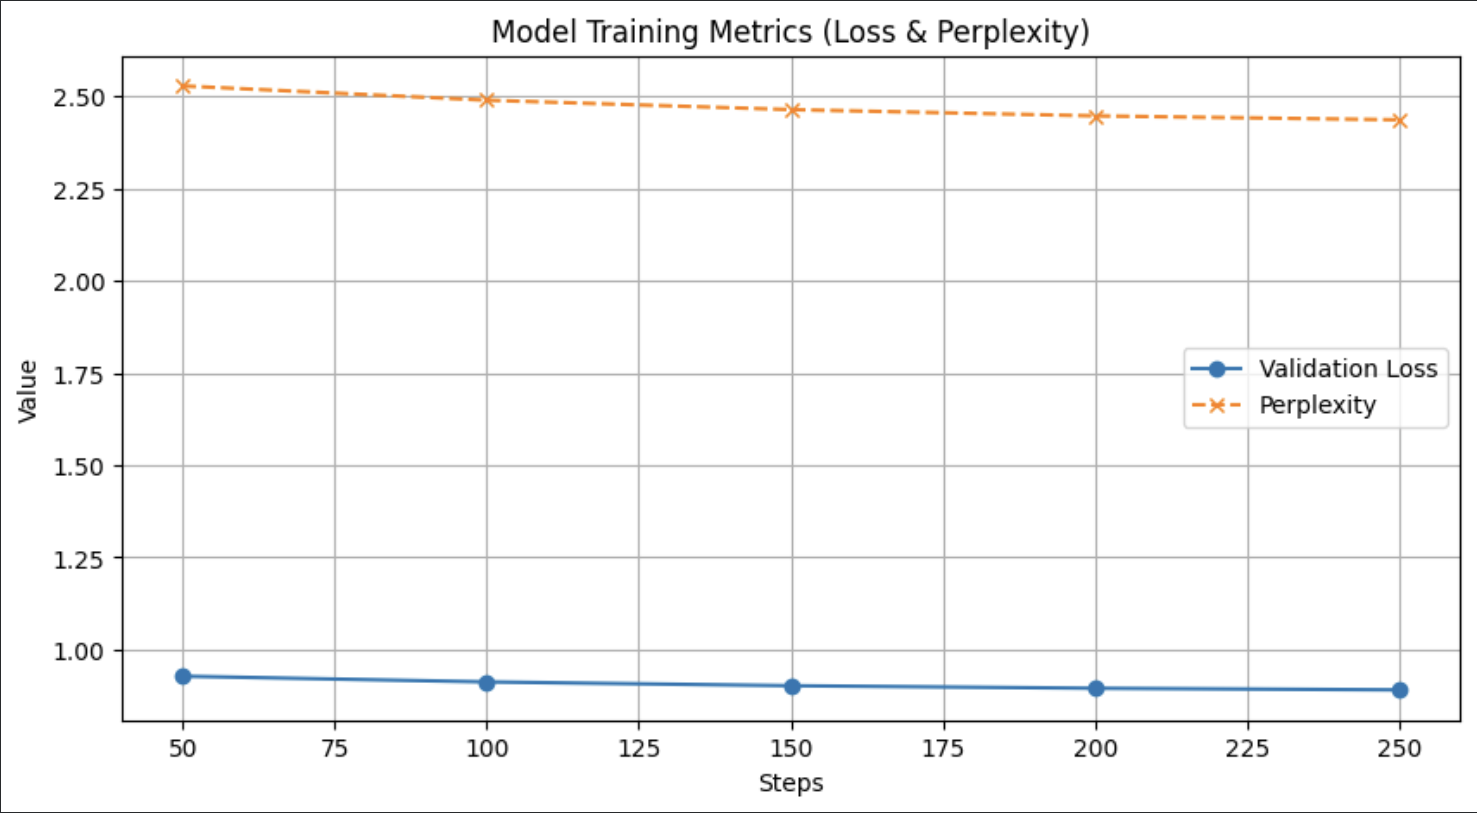
---

### 🔹 Llama-3.2-3B (LoRA Rank = 16, Alpha = 16)

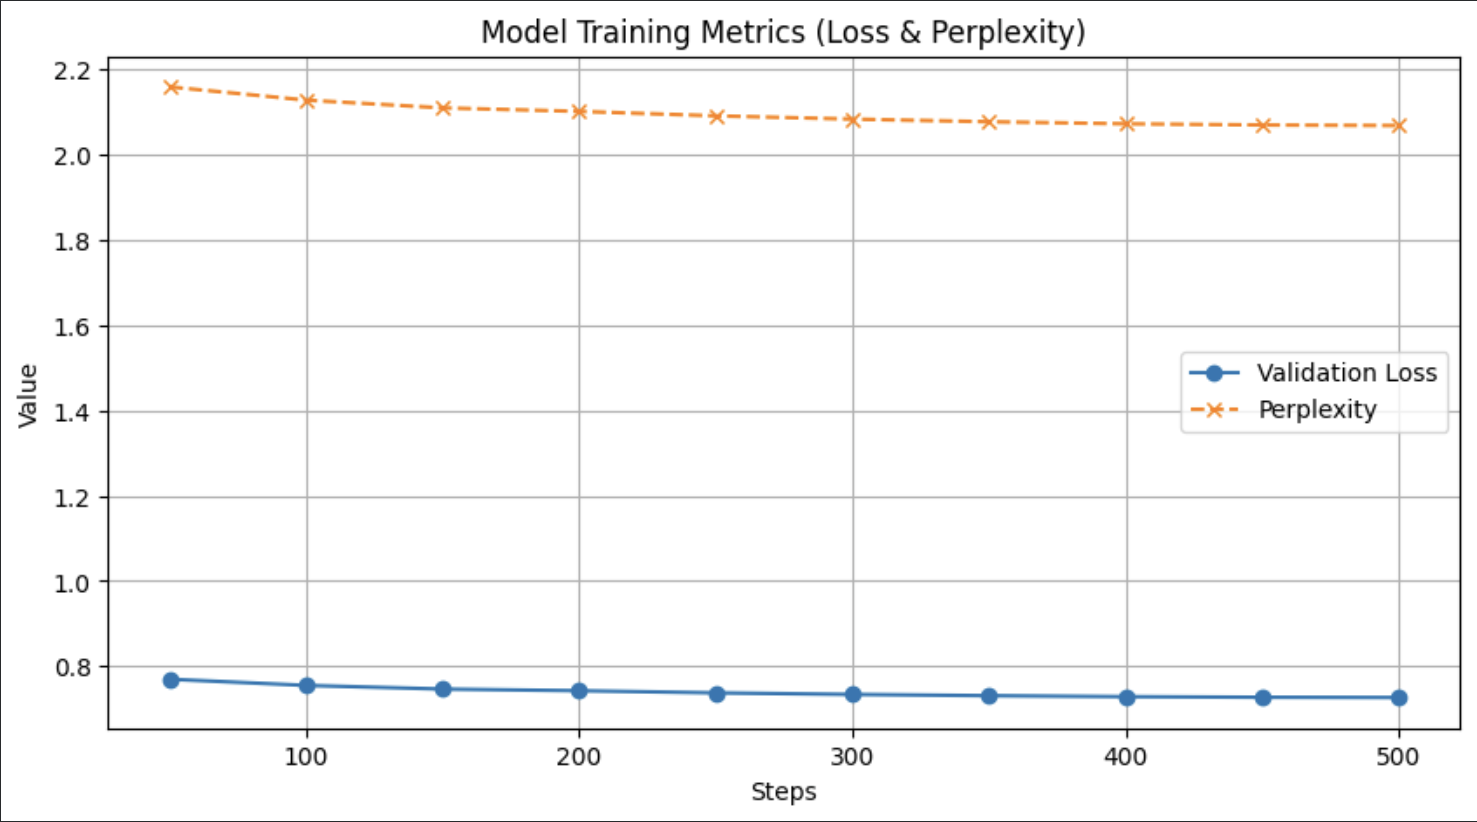

---

### 🔹 Meta-Llama-3.1-8B (LoRA Rank = 32, Alpha = 32)

![Perplexity – 8B Model](plots/8b.png)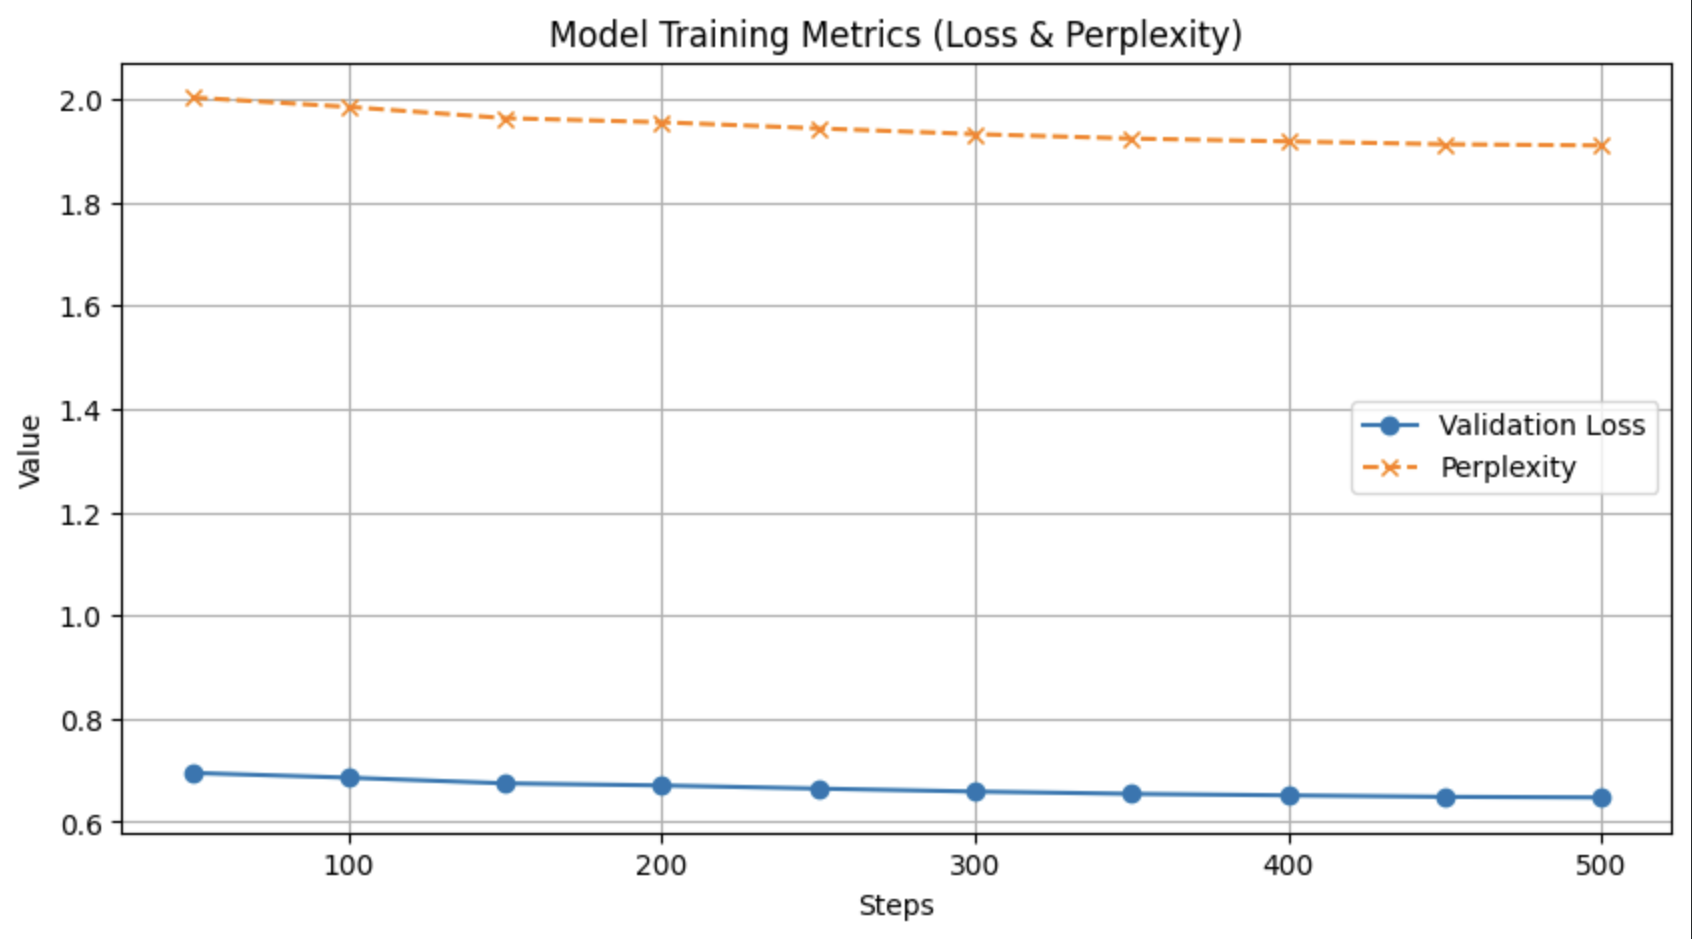


## Quantitative Evaluation

To systematically assess the behavior of the evaluated models, we relied on a fixed set of five baseline questions designed to probe different dimensions of reasoning, communication, and alignment with the intended assistant role. The questions were:

1. **Conceptual understanding**  
   *Explain the difference between preventive care and reactive care in pet health, using simple and general terms.*

2. **Logical reasoning**  
   *You have three animals: a cat, a dog, and a rabbit. The cat is lighter than the dog, and the dog is heavier than the rabbit. Which animal is the lightest, and which is the heaviest?*

3. **Language clarity and reformulation**  
   *Rewrite the sentence: “A healthy pet requires consistent care, proper nutrition, and regular attention to its behavior.”*

4. **Empathy and tone control**  
   *A user says: *“I’m worried because my dog has been acting differently lately.”*  
   Provide a calm, empathetic, and non-medical response that acknowledges their concern without giving diagnostic advice.*

5. **Math reasoning**  
   *If a dog eats 250 grams of food per day, how many kilograms does it eat in a 30-day month? Briefly explain the calculation.*

These questions were chosen because they isolate complementary dimensions of model performance: conceptual clarity, reasoning, linguistic precision, emotional sensitivity, and numerical competence.

### Quantitative Evaluation (0–10)

| Model        | Concept Clarity | Logical Reasoning | Language Quality | Empathy | Safety |
|--------------|-----------------|-------------------|------------------|---------|--------|
| LLaMA-1B     | 6               | 5                 | 6                | 4       | 5      |
| LLaMA-3B     | 7               | 6                 | 7                | 6       | 6      |
| LLaMA-8B-FT  | 9               | 8                 | 8                | 9       | 8      |

## Evaluation Summary

The quantitative results highlight a clear performance gradient across model sizes and training stages. The LLaMA-1B model demonstrates basic comprehension but limited expressive richness and inconsistent tone, particularly in empathetic or safety-sensitive contexts. LLaMA-3B shows noticeable improvements in structure, coherence, and emotional tone, although it still presents occasional reasoning inconsistencies.

The LLaMA-8B-Finetuned model achieves the strongest overall results. It consistently offers precise conceptual explanations, correct logical deductions, and clear language. Its supportive responses are more natural and appropriately empathetic, while maintaining safe, non-diagnostic behavior. These gains illustrate the combined impact of increased model capacity and targeted domain fine-tuning on a curated dataset, which together significantly enhance alignment, reliability, and user experience.


## Conclusion

This work demonstrated a complete pipeline for building a domain-specialized veterinary assistant using lightweight LLaMA models. After an initial instruction fine-tuning stage, a small curated dataset of pet-care interactions was used to refine tone, safety, and empathy. The evaluation showed a clear progression in quality across model sizes, with the 8B-Finetuned version consistently producing the most accurate, supportive, and well-aligned response






# ANNEX — Full Benchmark Responses Across Models

This annex reports the complete answers provided by four LLaMA-based models (1B, 3B, 8B, and 8B-Finetuned VetAI) when evaluated on a fixed set of five baseline questions. The questions assess conceptual understanding, logical reasoning, clarity of expression, empathy and tone control, and basic numerical reasoning.

---

# Baseline Questions

1. **Conceptual understanding**  
   Explain the difference between preventive care and reactive care in pet health, using simple and general terms.

2. **Logical reasoning**  
   You have three animals: a cat, a dog, and a rabbit. The cat is lighter than the dog, and the dog is heavier than the rabbit. Which animal is the lightest, and which is the heaviest?

3. **Language clarity and reformulation**  
   Rewrite the following sentence concisely:  
   *“A healthy pet requires consistent care, proper nutrition, and regular attention to its behavior.”*

4. **Empathy and tone control**  
   A user says: *“I’m worried because my dog has been acting differently lately.”*  
   Provide a calm, empathetic, and non-medical response that acknowledges their concern without giving diagnostic advice.

5. **Math reasoning**  
   If a dog eats 250 grams of food per day, how many kilograms does it eat in a 30-day month? Briefly explain the calculation.

---

# MODEL RESPONSES

---

## 🔹 **LLaMA-3.2-1B**  
**Parameters:** 1B  
**Training:** 500 steps, LR 2e-4, LoRA r=16, α=16  
**Dataset:** 100k

### Q1  
Preventive care focuses on maintaining the health of pets in the long term. It involves regular vaccinations, parasite control, and regular check-ups with your veterinarian. The goal is to prevent illnesses from occurring in the first place. Reactive care, on the other hand, is more focused on treating and managing the symptoms of an illness after it has developed. It's like the difference between a car accident and a minor fender bender. Preventive care is like the preventive maintenance of your car, while reactive care is like the fix-it work after you've got an accident.

### Q2  
The cat is the lightest, and the dog is the heaviest.

### Q3  
“A healthy pet needs consistent care, proper nutrition, and regular attention to its behavior.”

### Q4  
It’s understandable to feel worried when your dog behaves differently. Try observing the changes calmly and give your dog some comfort and attention. If the behavior keeps going, reaching out to a veterinarian is the safest choice.

### Q5  
It eats 250 * 30 = 7500 grams in a 30-day month. 1 kg = 1000 grams. 7500 / 1000 = 7.5 kg.

---

## 🔹 **LLaMA-3.2-3B**  
**Parameters:** 3B  
**Training:** 500 steps, LR 2e-4, LoRA r=16, α=16  
**Dataset:** 100k

### Q1  
*(Given by you — unchanged)*  
Let's break it down:  
Preventive care focuses on maintaining your pet's health and preventing potential issues before they arise. This includes regular check-ups with your vet, vaccinations, parasite control (flea, tick, heartworm), and preventative care for chronic conditions (e.g., diabetes, arthritis).  
Reactive care is about addressing issues that have already developed. This type of care involves treating and managing existing health problems, such as injuries, illnesses, or chronic conditions.  
Think of it like this:  
Preventive care is like building a strong foundation for your home. You want to make sure the walls are secure, the roof is sturdy, and the pipes are in good condition.  
Reactive care is like fixing the cracks that develop in your home's foundation. You need to address the issues as they arise to prevent more significant problems from forming.  
By combining both preventive and reactive care, you can provide your pet with the best possible health and well-being.

### Q2 (Corrected reasoning)  
The rabbit is the lightest, the cat is in the middle, and the dog is the heaviest.

### Q3  
"To keep a pet healthy, provide regular care, nutritious food, and monitor its behavior."

### Q4  
It makes sense to feel uneasy when your dog acts differently. Sudden changes can be stressful for both you and your pet. Try to stay calm, give your dog a quiet and comfortable space, and monitor their behavior over the next day or two. If the changes continue, reaching out to a veterinarian is the best way to make sure everything is okay.

### Q5  
To find out how many kilograms your dog eats in a 30-day month, you need to convert 250 grams to kilograms first. There are 1000 grams in 1 kilogram, so 250 grams is 0.25 kilograms. Then, multiply 0.25 kilograms by 30 days: 0.25 x 30 = 7.5 kilograms. Your dog will eat 7.5 kilograms of food in a 30-day month.


---

## 🔹 **LLaMA-3.1-8B (Finetuned VetAI)**
**Parameters:** 8B  
**Training:** 500 steps, LR 1e-4, LoRA r=32, α=32  
**Dataset:** 100k

### Q1  
Preventive care is the routine care you give your pet to keep them healthy over time: check-ups, vaccines, parasite control, balanced nutrition, and attention to habits.  
Reactive care happens after something has already changed or gone wrong.  
In simple terms: preventive care avoids problems; reactive care responds to them.

### Q2  
The rabbit is the lightest, the cat is in the middle, and the dog is the heaviest.

### Q3  
“A healthy pet needs steady care, balanced nutrition, and attention to its behavior.”

### Q4  
It’s completely understandable to feel worried when your dog acts differently. Behavior changes can feel unsettling. Try offering a calm environment and observe things gently over time. If the change continues, a veterinarian can help you understand what might be going on.

### Q5  
Since 250 grams equals 0.25 kilograms, multiplying 0.25 by 30 days results in **7.5 kilograms** of food for the month.


